<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [4]:
import os
import datetime
import numpy as np
import re
import warnings
import pandas as pd
import calendar
import pickle
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [41]:
def load_data(data_path):
    
    stock_news_df = pd.read_csv(data_path + 'news_reuters.csv', header=None,
                                names=['tickers', 'company', 'date', 'headline', 'first_sent', 'priority'])

    with open(data_path + 'stockReturns.json') as f:
        stock_price = json.load(f)    
    stock_price_df = pd.DataFrame(stock_price)
    
    return stock_news_df, stock_price_df


def transform_stock_price(price_df, duration):

    transform_df = price_df[duration].apply(pd.Series)
    transform_df = transform_df.stack().rename('price_change' + '_' + duration).reset_index()
    transform_df.rename(columns={'level_0': 'tickers', 'level_1': 'date'}, inplace=True)
    transform_df.date = transform_df.date.astype('int64')
    
    if duration == 'short':
        transform_df['signal'] = transform_df['price_change' + '_' + duration] \
        .map(lambda x: "stay" if -1 < x < 1 else ("up" if x > 1 else "down"))
    return transform_df


def combine_stock_news(news_df, price_df):
    
    combined_df = news_df.copy()
    
    durations = price_df.columns
    for duration in durations:
        price_duration_df = transform_stock_price(price_df, duration)
        combined_df = pd.merge(left=combined_df, right=price_duration_df,
                       on=['date', 'tickers'], how='inner')
    return combined_df


def to_csv(data_path):
    
    news_df, price_df = load_data(data_path)
    
    combined_df = combine_stock_news(news_df, price_df)
    
    combined_df.to_csv(data_path + "news_price_df.csv")
    
    

def cleanup_text(sent):
    
    monthStrings = list(calendar.month_name)[1:] + list(calendar.month_abbr)[1:]
    monthPattern = '|'.join(monthStrings)
    sent = re.sub(r'\s+', ' ', str(sent)).strip()
    sent = re.sub(r'\/+', '', sent)
    sent = re.sub(r'U.S.', 'United States', sent)
    sent = re.sub(r'CORRECTED-', '', sent)
    sent = re.sub(r'^(\W?[A-Z\s\d]+\b-?)', '', sent)
    sent = re.sub(r'^ ?\W ', '', sent)
    sent = re.sub(r'(\s*-+\s*[A-Za-z]+)$', '', sent)
    sent = re.sub(r"(\'+[A-Z1-9]+\'*)$", '', sent)
    sent = re.sub(r"[$'|]+", '', sent)
    sent = re.sub(r'({}) \d+'.format(monthPattern), '', sent)
    
    sent = sent.lower().strip()
    
    return sent


def spacy_tokenize(df, col):
    
    nlp = English()
    STOP_WORDS = construct_stop_words()
    sentences = df[col].tolist()
    docs = []
    for sent in sentences:
        docs.append(cleanup_text(sent))

    def token_filter(token, stop_words):
        return not (token.is_punct or token.is_stop or token.is_space)

    try:
        filtered_tokens = []
        for doc in nlp.pipe(docs):
            tokens = [tok.lemma_ for tok in doc if token_filter(tok, STOP_WORDS)]
            tokens = [tok for tok in tokens if not re.search('[\$1-9]+', tok)]
            filtered_tokens.append(tokens)
            
        return filtered_tokens
    except Exception as e:
        raise e


def construct_stop_words():
    stop_words_list = ["uk", "ceo", "apple", "wal",  "st", "q1", "q2", "q3", "q4", 
                       "bp", "wednesday", "tuesday", "monday", "thursday", "friday", "sept", "johnson", "inc", 
                       "david", "amazon.com"]
    
    for words in stop_words_list:
        STOP_WORDS.add(words)
    
    return STOP_WORDS


def check_top_vocab(df, text_col, pos_tag):
    
    nlp = spacy.load('en_core_web_lg')
    cleaned_tokens = df[text_col].to_list()
    cleaned_sent = [" ".join(sent) for sent in cleaned_tokens]
    
    pos_count = {}
    for doc in nlp.pipe(cleaned_sent):
        for token in doc:

            if token.is_stop or token.is_punct or token.is_space:
                continue

            if token.pos_ == 'PROPN':

                if token.lemma_ in pos_count:
                    pos_count[token.lemma_] += 1
                else:
                    pos_count[token.lemma_] = 1

    return pos_count


def limit_to_one_news(news):
    if news.shape[0] > 1:
        if 'topStory' in news['priority'].unique():
            news = news.loc[news['headline'] == "topStory"]
        if news.shape[0] > 1:
            news = news.sample(n=1, random_state=12)
    return news

In [36]:
data_path = "../inputs/"
news_df, price_df = load_data(data_path)

In [39]:
stock_news_df = combine_stock_news(news_df, price_df)
#to_csv(data_path)
print(stock_news_df.shape)

(148195, 10)


In [49]:
stock_news_df.columns

Index(['tickers', 'company', 'date', 'headline', 'first_sent', 'priority',
       'price_change_short', 'price_change_mid', 'signal',
       'price_change_long'],
      dtype='object')

In [42]:
filtered_tokens = spacy_tokenize(stock_news_df, 'headline')
filtered_tokens_first_sent = spacy_tokenize(stock_news_df, "first_sent")

In [43]:
transformed_news_df = stock_news_df.copy()
transformed_news_df['headlines_tokens'] = filtered_tokens
transformed_news_df['first_sent_tokens'] = filtered_tokens_first_sent
transformed_news_df['head_tok_len'] = transformed_news_df['headlines_tokens'].map(lambda x: len(x))
transformed_news_df['sent_tok_len'] = transformed_news_df['first_sent_tokens'].map(lambda x: len(x))

In [44]:
transformed_news_df = transformed_news_df.groupby(['tickers', 'date']).apply(limit_to_one_news)
transformed_news_df['combined_tokens'] = transformed_news_df.headlines_tokens \
    + transformed_news_df.first_sent_tokens
transformed_news_df['combined_len'] = transformed_news_df.head_tok_len \
    + transformed_news_df.sent_tok_len
transformed_news_df = transformed_news_df.droplevel([0,1])

In [45]:
transformed_news_df.shape

(24863, 16)

In [46]:
pos_count =  check_top_vocab(transformed_news_df, "combined_tokens", "NOUN")
print("top 10 VERBs {}".format(sorted(pos_count.items(), key=lambda kv: kv[1], reverse=True)[:50]))

top 10 VERBs [('plc', 463), ('google', 305), ('america', 221), ('china', 217), ('fitch', 143), ('john', 137), ('july', 136), ('bbb+', 119), ('ebay', 107), ('sachs', 100), ('amgen', 96), ('washington', 94), ('obama', 92), ('barclays', 91), ('california', 90), ('bristol', 89), ('sanofi', 88), ('goldman', 88), ('europe', 83), ('michael', 82), ('viacom', 81), ('a+', 74), ('november', 73), ('cnbc', 72), ('s.a', 70), ('myers', 70), ('james', 69), ('spain', 66), ('j.c', 65), ('corp', 63), ('allergan', 62), ('ibm', 62), ('citigroup', 61), ('frances', 60), ('january', 60), ('canada', 60), ('ryanair', 60), ('japan', 59), ('ford', 58), ('halliburton', 58), ('kkr', 58), ('nokia', 58), ('hsbc', 57), ('texas', 57), ('william', 56), ('valero', 56), ('robert', 54), ('mart', 53), ('icahn', 53), ('hess', 53)]


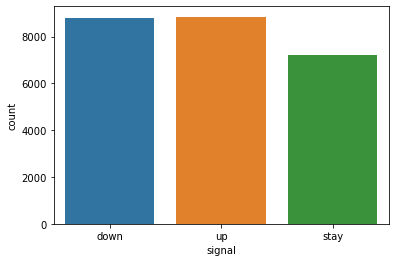

In [47]:
sns.countplot(transformed_news_df['signal']);

In [48]:
transformed_news_df["combined_len"].describe()

count    24863.000000
mean        24.564413
std          9.745508
min          0.000000
25%         17.000000
50%         24.000000
75%         29.000000
max        148.000000
Name: combined_len, dtype: float64

In [27]:
data_types_df = transformed_news_df.dtypes.astype(str).to_dict()
with open('inputs/data_type_key.json', 'w', encoding='utf-8') as f:
    json.dump(data_types_df, f)

In [26]:

transformed_news_df.to_csv("inputs/preprocessed_news.csv")